<div class="alert alert-block alert-info">

# Portfolio-Exam Customer Personality Analysis
## Table of Contents
## Story and Background
My Name is Tom Ruge, founder and CEO of my own cosulting company called <strong>TickleTech Consulting: Where solutions are just a touch away!</strong>. I took part at a competitive pitch for convincing a retail company to choose me to analyze their customer and retail data. I won the competitive pitch and will draw coclusions of their data in this JUpyter Notebook. This company sells a big variety of products both online and offline. Their stock contains everything from food to cleaning products to car tires and therefore attrackts all kind of customers. The company gathered information about their purchase channels, sozioeconomic information about the customers, how much they spent on products and whether they were influenced by promotion campaings or not. At first i will provide you with generall information about the data and will draw conclusions so your company will be able to understand your ciustomers in a better way. Then I will apply cluster algorithms in order to find groups of people and properties, which enables your company to better adress your customers by adapting your stocks. Clustering, in the context of data analysis and machine learning,refers to the task of grouping a set of objects in such a way that objects in the same group (or cluster) are more similar to each other than to those in other groups. Even if no groups ca be found, you will gain a unique insight into your business. <strong>Let us make the world a better place to be a customer</strong>.
</div>

In [31]:
# IMport all necesary librarys
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

In [32]:
# specify the path to the data set
path = '/home/tomruge/Schreibtisch/Data/FH/marketing_campaign.csv'
# Using pyarrow as engine to read the data set. It is faster than the default engine.
data = pd.read_csv(path, delimiter='\t')
# ID already exists in the data set, so we can use it as index
data.set_index('ID', inplace=True)



<div class="alert alert-block alert-info">
<a id =exercise1><h2> Load Data and Preprocessing</h2></a>
</div>

In [33]:

# Dt_Customer is a date column, so we need to convert it to datetime
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'], format='%d-%m-%Y')

# Year_Birth needs to be transformed to datetime
data['Year_Birth'] = pd.to_datetime(data['Year_Birth'], format='%Y')


<div class="alert alert-block alert-info">
<a id =exercise1><h2>Feature Engineering</h2>  </a id =exercise1.1>
</div>

In [34]:
# Age is difference between the Dt_Customer and Year_Birth, since it was probably the time where the measurement was taken
data['Age'] = (data['Dt_Customer'].dt.year - data['Year_Birth'].dt.year).astype(int)

# create a column for overall spending by adding all the spending columns
data['MntAll'] = data['MntWines'] + data['MntFruits'] + data['MntMeatProducts'] + data['MntFishProducts'] + data['MntSweetProducts'] + data['MntGoldProds']

# combine children and teen to one column
data['Children'] = data['Kidhome'] + data['Teenhome'] 

# is parent or not
data['IsParent'] = np.where((data['Kidhome'] > 0) | (data['Teenhome'] > 0), 1, 0)

# how many deals accepted
data['AcceptedAnyDeal'] = data['AcceptedCmp1'] + data['AcceptedCmp2'] + data['AcceptedCmp3'] + data['AcceptedCmp4'] + data['AcceptedCmp5']

# Living with or not
data['LivingTogether'] = np.where((data['IsParent'] > 0) | (data['Marital_Status'] != 'Together') | (data['Marital_Status'] != 'Married'), 1, 0)

# accepted any deal or not
data['AcceptedAnyDeal'] = np.where(data['AcceptedAnyDeal'] > 0, 1, 0)

# create a income per people column, the plus 1 is to avoid division by zero, should also consider marital status
data['IncomePerPerson'] = data['Income'] / (data['Children'] + 1)

# drop Z_CostContact and Z_Revenue since they are constant
data.drop(['Z_CostContact', 'Z_Revenue'], axis=1, inplace=True)


<div class="alert alert-block alert-info">
<a id =exercise1><h2>Initial Data Analysis (IDA)</h2>  </a id =exercise1.1>
</div>

<div class="alert alert-block alert-info">

### Dataset Attributes

#### People

- **ID**: Unique identifier for each customer
- **Year_Birth**: Year of birth of the customer
- **Education**: Level of education attained by the customer
- **Marital_Status**: Marital status of the customer
- **Income**: Yearly household income of the customer
- **Kidhome**: Number of children in the customer's household
- **Teenhome**: Number of teenagers in the customer's household
- **Dt_Customer**: Date of customer's enrollment with the company
- **Recency**: Number of days since the customer's last purchase
- **Complain**: Indicates whether the customer complained in the last 2 years (1 for yes, 0 for no)

#### Products

- **MntWines**: Amount spent on wine in the last 2 years
- **MntFruits**: Amount spent on fruits in the last 2 years
- **MntMeatProducts**: Amount spent on meat in the last 2 years
- **MntFishProducts**: Amount spent on fish in the last 2 years
- **MntSweetProducts**: Amount spent on sweets in the last 2 years
- **MntGoldProds**: Amount spent on gold in the last 2 years

#### Promotion

- **NumDealsPurchases**: Number of purchases made with a discount
- **AcceptedCmp1-5**: Indicates whether the customer accepted the offer in each of the 5 campaigns (1 for yes, 0 for no)
- **Response**: Indicates whether the customer accepted the offer in the last campaign (1 for yes, 0 for no)

#### Place

- **NumWebPurchases**: Number of purchases made through the company’s website
- **NumCatalogPurchases**: Number of purchases made using a catalogue
- **NumStorePurchases**: Number of purchases made directly in stores
- **NumWebVisitsMonth**: Number of visits to company’s website in the last month

As one can see, tha dataset contains many attributes which can be grouped in 4 parent grous. Sozioeconimic data, how much did they spent on specific products, the consequences of 5 different promotion campaigns and where the customers bought the goods.

</div>


In [35]:
# display all the columns. dont truncate the output
pd.set_option('display.max_columns', None)
# first look at the data set
display(data.head())
print(data.columns)

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,MntAll,Children,IsParent,AcceptedAnyDeal,LivingTogether,IncomePerPerson
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5524,1957-01-01,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,55,1617,0,0,0,1,58138.0
2174,1954-01-01,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,60,27,2,1,0,1,15448.0
4141,1965-01-01,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,48,776,0,0,0,1,71613.0
6182,1984-01-01,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,30,53,1,1,0,1,13323.0
5324,1981-01-01,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,33,422,1,1,0,1,29146.5


Index(['Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Response', 'Age', 'MntAll', 'Children',
       'IsParent', 'AcceptedAnyDeal', 'LivingTogether', 'IncomePerPerson'],
      dtype='object')


In [36]:
# NUmber of attributes and number of different customers in the data set
print('Number of attributes:', data.shape[1], '\nNumber of different customers:', data.shape[0])

Number of attributes: 33 
Number of different customers: 2240


In [37]:
# The dataset contains missing values
missing_values = data.isnull().sum()
print('Missing values:\n',missing_values[missing_values != 0])

# dropping all rows with missing values
data.dropna(inplace=True)


Missing values:
 Income             24
IncomePerPerson    24
dtype: int64


<div class="alert alert-block alert-info">
    The dataset contains 24 missing values, all within the same attribute column. Given that this represents only 1% of the data, it's reasonable to drop these rows under the assumption that they were 'randomly' selected. As such, they won't form an individual cluster. Even if these rows were to potentially form a cluster on their own, the number of missing values is not statistically significant enough to warrant concern. So they can just be dropped.
</div>


In [38]:
pd.set_option('display.max_columns', None)
display(data.describe())

,Year_Birth,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,MntAll,Children,IsParent,AcceptedAnyDeal,LivingTogether,IncomePerPerson
count,2216,2216.000000,2216.000000,2216.000000,2216,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.0,2216.000000
mean,1968-10-27 00:27:56.534296032,52247.251354,0.441787,0.505415,2013-07-10 11:29:27.509025280,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,2.323556,4.085289,2.671029,5.800993,5.319043,0.073556,0.074007,0.073105,0.064079,0.013538,0.009477,0.150271,44.208032,607.075361,0.947202,0.714350,0.207130,1.0,33848.909446
min,1893-01-01 00:00:00,1730.000000,0.000000,0.000000,2012-07-30 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.000000,5.000000,0.000000,0.000000,0.000000,1.0,1223.500000
25%,1959-01-01 00:00:00,35303.000000,0.000000,0.000000,2013-01-16 00:00:00,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,36.000000,69.000000,0.000000,0.000000,0.000000,1.0,15408.375000
50%,1970-01-01 00:00:00,51381.500000,0.000000,0.000000,2013-07-08 12:00:00,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,43.000000,396.500000,1.000000,1.000000,0.000000,1.0,24752.000000
75%,1977-01-01 00:00:00,68522.000000,1.000000,1.000000,2013-12-31 00:00:00,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,54.000000,1048.000000,1.000000,1.000000,0.000000,1.0,39026.500000
max,1996-01-01 00:00:00,666666.000000,2.000000,2.000000,2014-06-29 00:00:00,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,121.000000,2525.000000,3.000000,1.000000,1.000000,1.0,333333.000000
std,NaN,25173.076661,0.536896,0.544181,NaN,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,1.923716,2.740951,2.926734,3.250785,2.425359,0.261106,0.261842,0.260367,0.244950,0.115588,0.096907,0.357417,12.023812,602.900476,0.749062,0.451825,0.405341,0.0,25912.847005


### Thoughts

Income:
- Income min seems way too low. maybe sometimes prefixes wrong? Maximum seems like a Satan troll. But the 50% percentile seems resaonable. Also the standart devation seems reasonable.
Kidhome and Teenhome:
- in average every 2 people do have one child. -> Each pair has one child.
Dt_Customer:
- The measurement was probably takren from 2012 to 2014. SO for 2 years.
Recency:
- The 50% percetile lies at 50. So 50 percent of the people....
Products:
- Wine is the most profitable. Cana Analize this more.


... i need to analze more...


<div class="alert alert-block alert-info">
<h2>Exploratory Data Analysis (EDA)</h2>
<h3>Univariate Data Analysis</h3>
<h4>Categorical Variables</h4>



At first we will look at the sozio-econimic data.
</div>


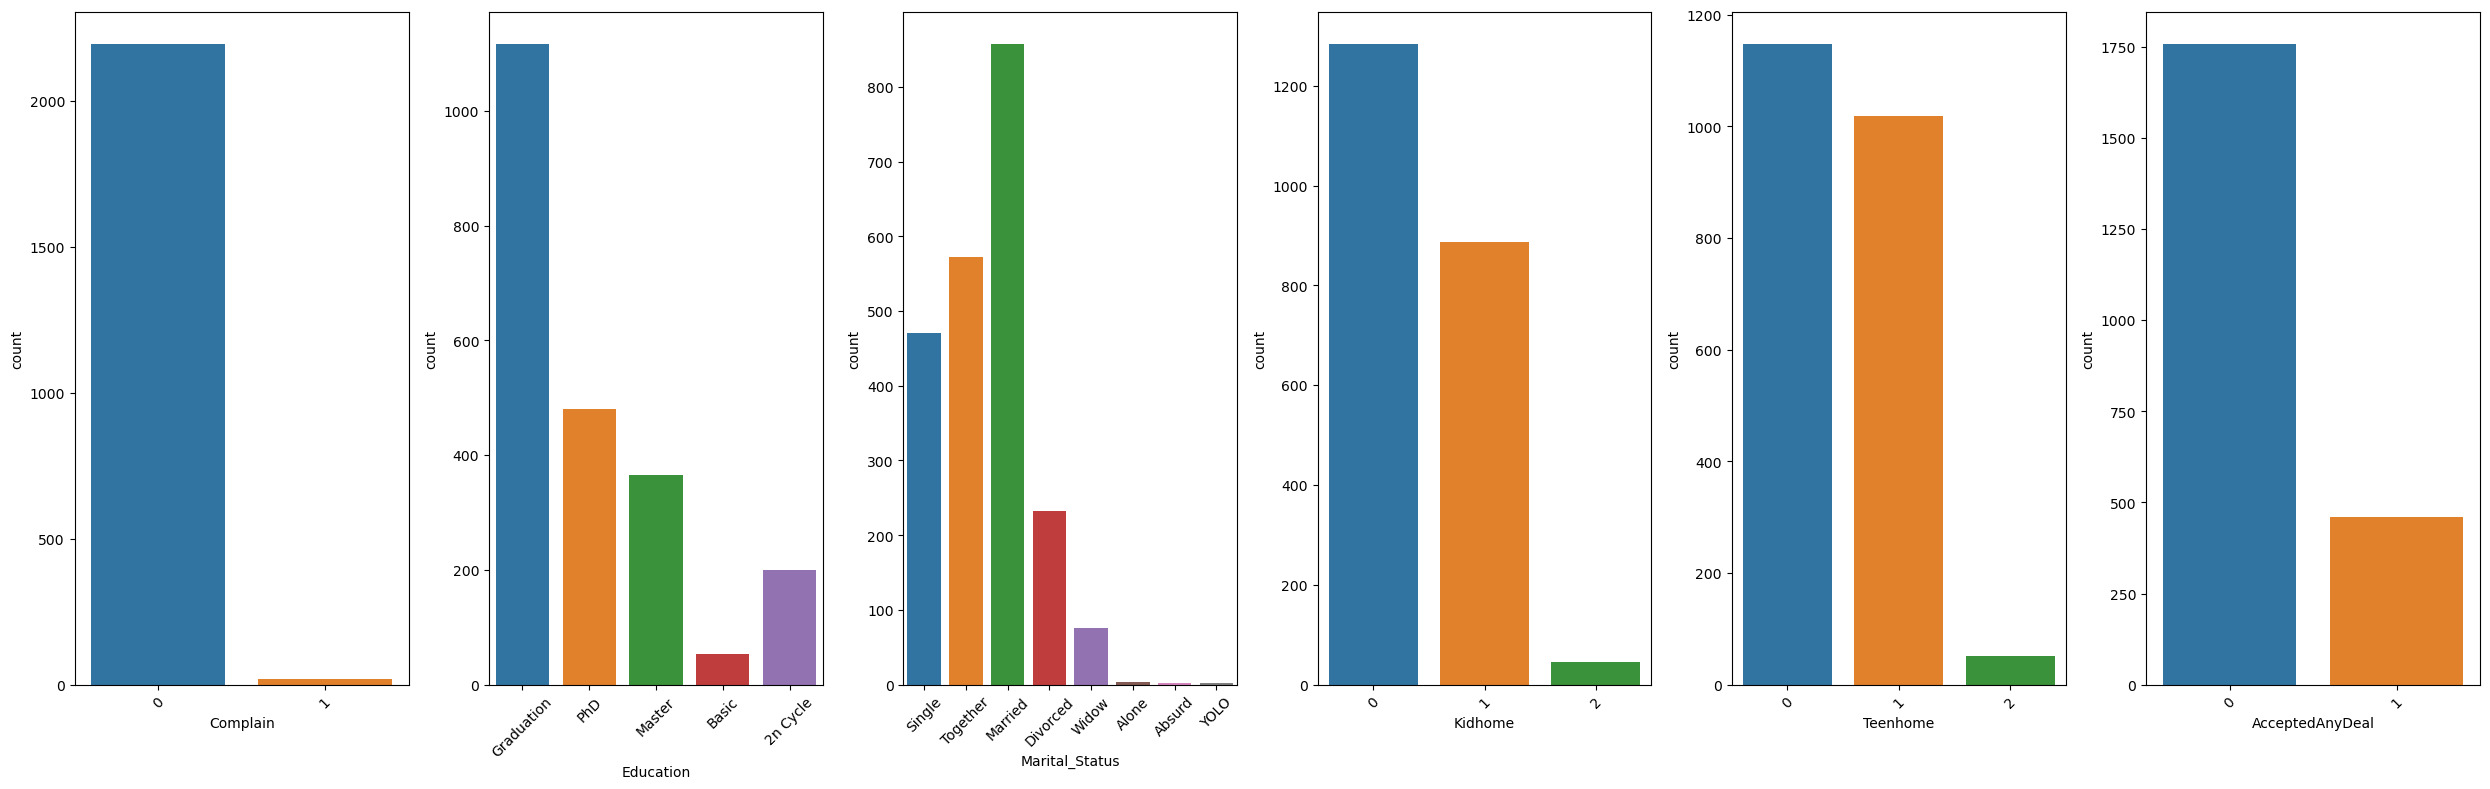

In [39]:
cal_cols = ['Complain', 'Education', 'Marital_Status', 'Kidhome', 'Teenhome','AcceptedAnyDeal']
fig, ax = plt.subplots(1, len(cal_cols), figsize=(25, 8))
for col in enumerate(cal_cols):
    sns.countplot(data=data, x=col[1], ax=ax[col[0]])
    ax[col[0]].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

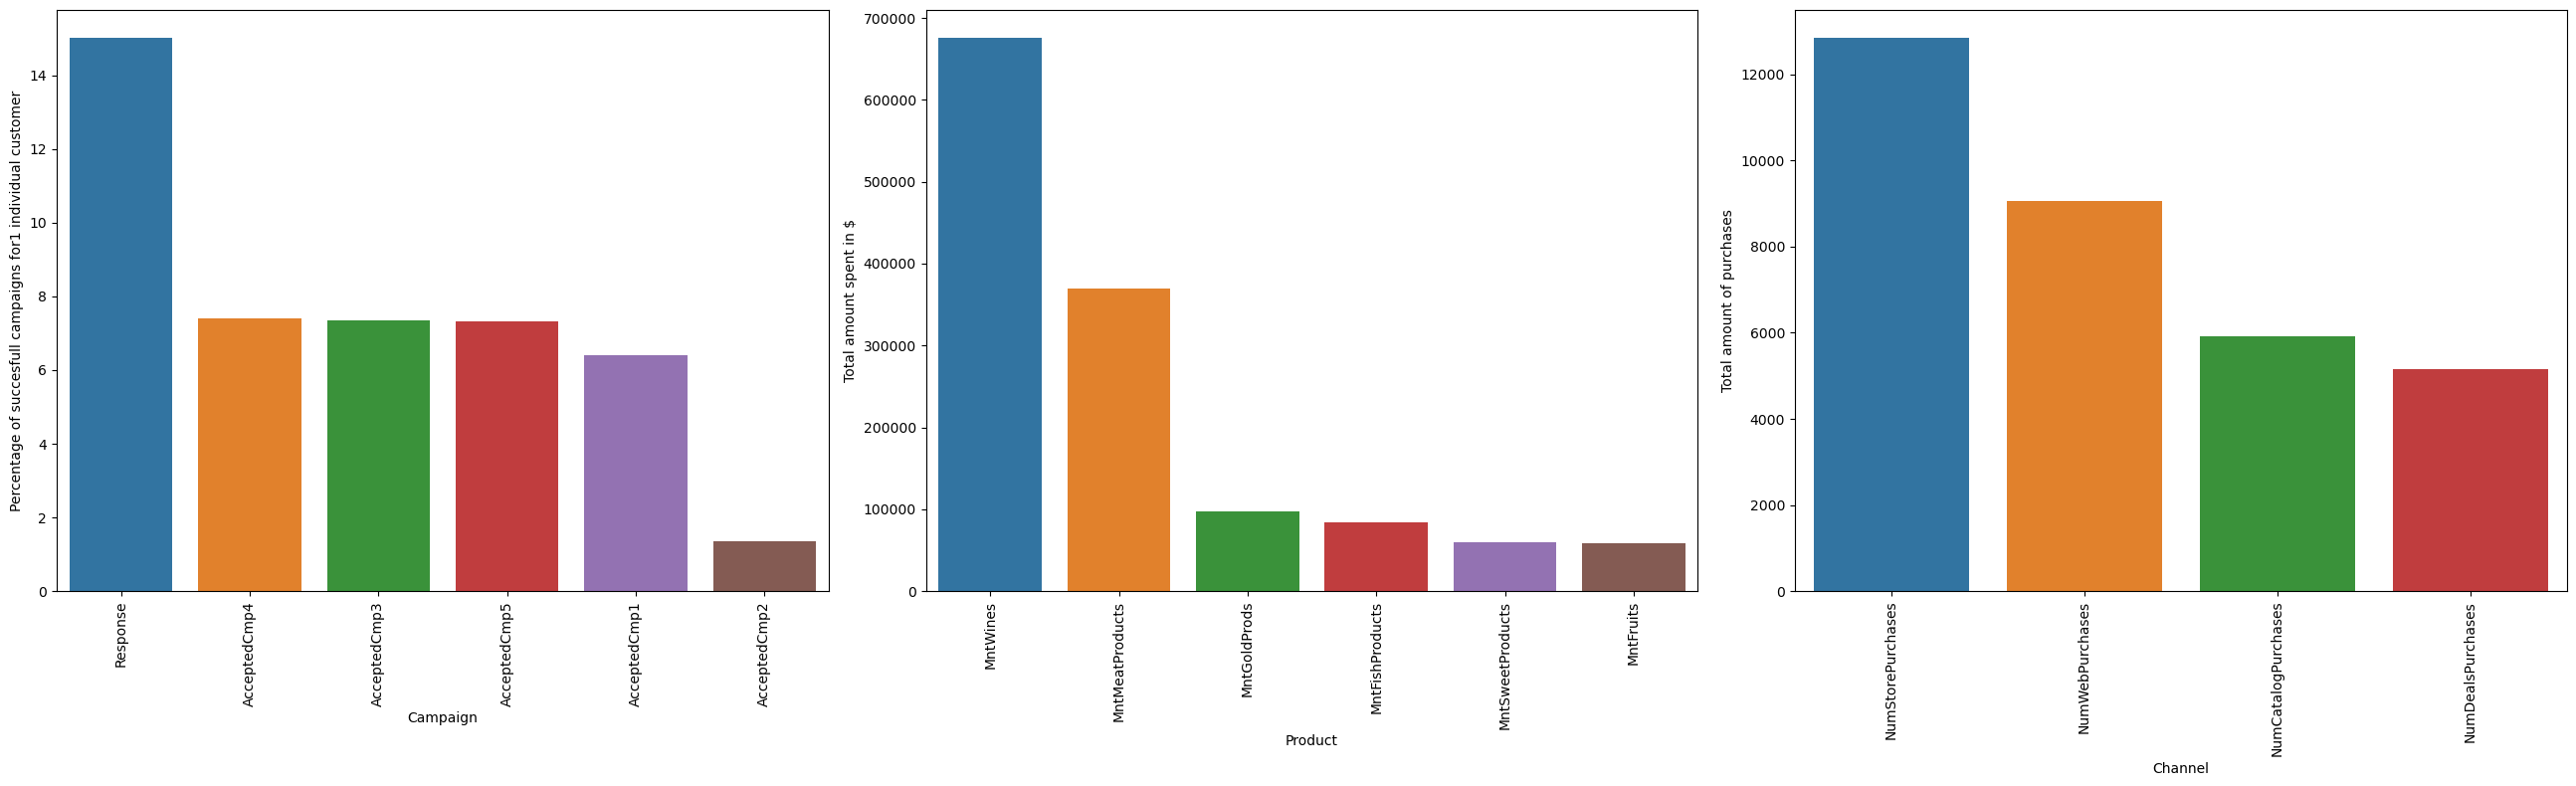

In [40]:
# What was the most succesfull campaign
def percentage(x):
    return x.sum() / x.count()*100

campaign_succes = data[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']].agg(percentage)
campaign_succes = campaign_succes.sort_values(ascending=False)
fig, ax = plt.subplots(1, 3, figsize=(26, 8))
# plot
sns.barplot(x=campaign_succes.index, y=campaign_succes, ax=ax[0])
ax[0].set_ylabel('Percentage of succesfull campaigns for1 individual customer')
ax[0].set_xlabel('Campaign')
ax[0].tick_params(axis='x', rotation=90)

# what is thoe most succesfull product?
sum_product = data[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']].sum()   
sum_product = sum_product.sort_values(ascending=False)

# plot
sns.barplot(x=sum_product.index, y=sum_product, ax=ax[1])
ax[1].set_ylabel('Total amount spent in $')
ax[1].set_xlabel('Product')
ax[1].tick_params(axis='x', rotation=90)


# interesting is also whether where the customers bought there products
sum_channel = data[['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']].sum()
sum_channel = sum_channel.sort_values(ascending=False)

sns.barplot(x=sum_channel.index, y=sum_channel, ax=ax[2])
ax[2].set_ylabel('Total amount of purchases')
ax[2].set_xlabel('Channel')
ax[2].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">

Complain:
- Less then 1% of the customers complain. The vast majority of the customers do not complain. It can not be concluded that the vast majority is satisfied with the services. 
Education:
- Graduation, Basic and 2n Ccle is at this moment for me not clearly defined. So it is not possible to draw propper coclusions. 
Marital_Status:
- Most of the customers at at least in a relationship or married. More than 50% of the customers.
Kidhome and Teenhome:
- Most do not have a kid at home or Teen at home. I should get more exact numbers. Anoying but better. It is remarkable that the customers have more teens at home then kids at home. It can be seen that the people probably get less children today then back in the days, assuming statistical significance and nor systematic errors for this hypothesis.

<h4>Continous Variables</h4>

</div>


/home/tomruge/anaconda3/envs/env3.12.2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/tomruge/anaconda3/envs/env3.12.2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/tomruge/anaconda3/envs/env3.12.2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/tomruge/anaconda3/envs/env3.12.2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na opti

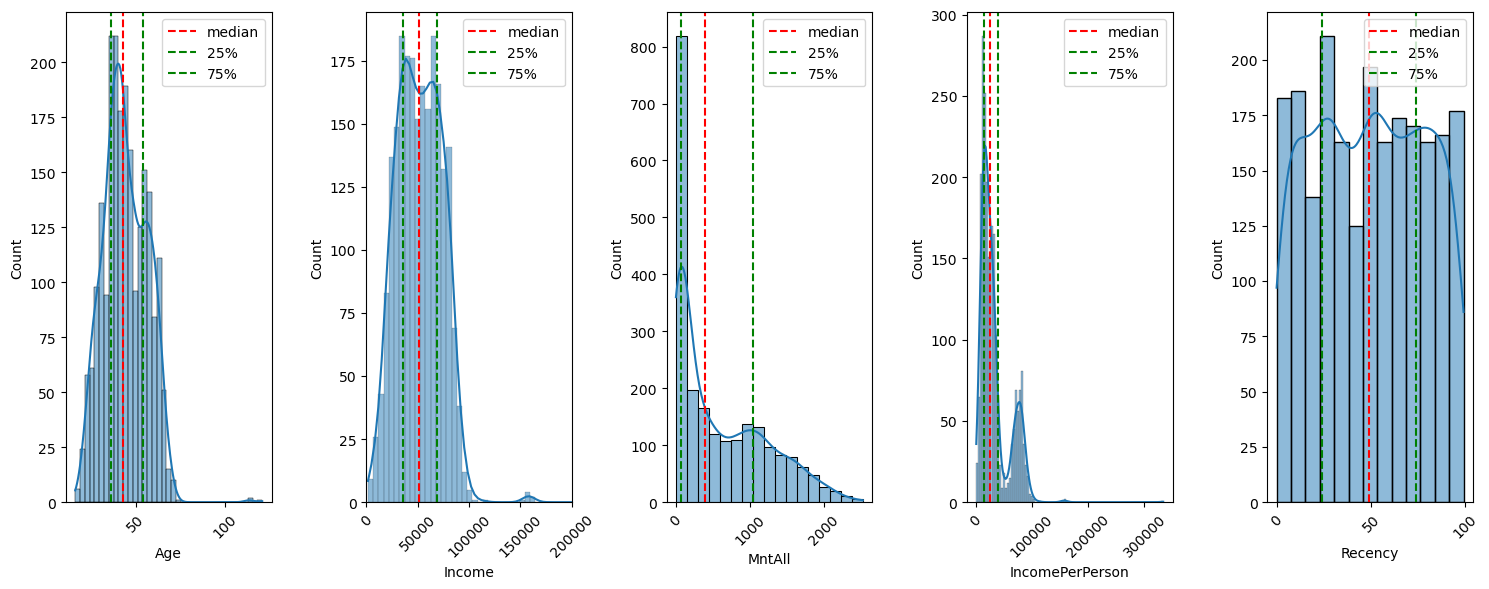

In [51]:
num_cols = ['Age', 'Income', 'MntAll', 'IncomePerPerson', 'Recency']
fig, ax = plt.subplots(1, len(num_cols), figsize=(15, 6))

def median_25_75(x):
    return x.median(), x.quantile(0.25), x.quantile(0.75)

for col in enumerate(num_cols):
    sns.histplot(data=data, x=col[1], ax=ax[col[0]], kde=True)
    median, q25, q75 = median_25_75(data[col[1]])
    ax[col[0]].axvline(median, color='r', linestyle='--', label='median')
    ax[col[0]].axvline(q25, color='g', linestyle='--', label='25%')
    ax[col[0]].axvline(q75, color='g', linestyle='--', label='75%')
    ax[col[0]].tick_params(axis='x', rotation=45)
    ax[col[0]].legend()

ax[1].set_xlim(0, 200000)
plt.tight_layout()
plt.show()

/home/tomruge/anaconda3/envs/env3.12.2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/tomruge/anaconda3/envs/env3.12.2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/tomruge/anaconda3/envs/env3.12.2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/tomruge/anaconda3/envs/env3.12.2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na opti

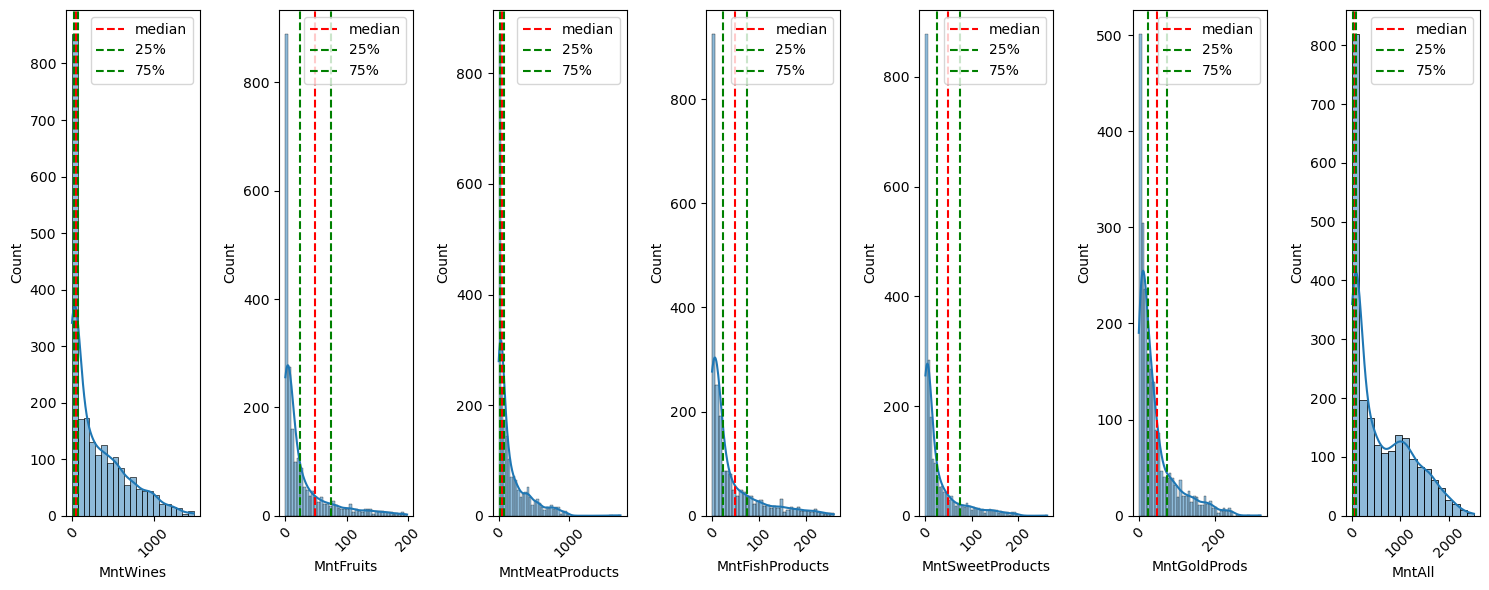

In [56]:
num_cols_mnt = ['MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds','MntAll']

def median_25_75(x):
    return x.median(), x.quantile(0.25), x.quantile(0.75)

fig, ax = plt.subplots(1, len(num_cols_mnt), figsize=(15, 6))
for col in enumerate(num_cols_mnt):
    sns.histplot(data=data, x=col[1], ax=ax[col[0]], kde=True)
    ax[col[0]].axvline(median, color='r', linestyle='--', label='median')
    ax[col[0]].axvline(q25, color='g', linestyle='--', label='25%')
    ax[col[0]].axvline(q75, color='g', linestyle='--', label='75%')
    ax[col[0]].tick_params(axis='x', rotation=45)
    ax[col[0]].legend()
        
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
<h4>Bivariat and Multivariat Analysis</h4>

</div>

/home/tomruge/anaconda3/envs/env3.12.2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/tomruge/anaconda3/envs/env3.12.2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/tomruge/anaconda3/envs/env3.12.2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/tomruge/anaconda3/envs/env3.12.2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na opti

<Figure size 2000x600 with 0 Axes>

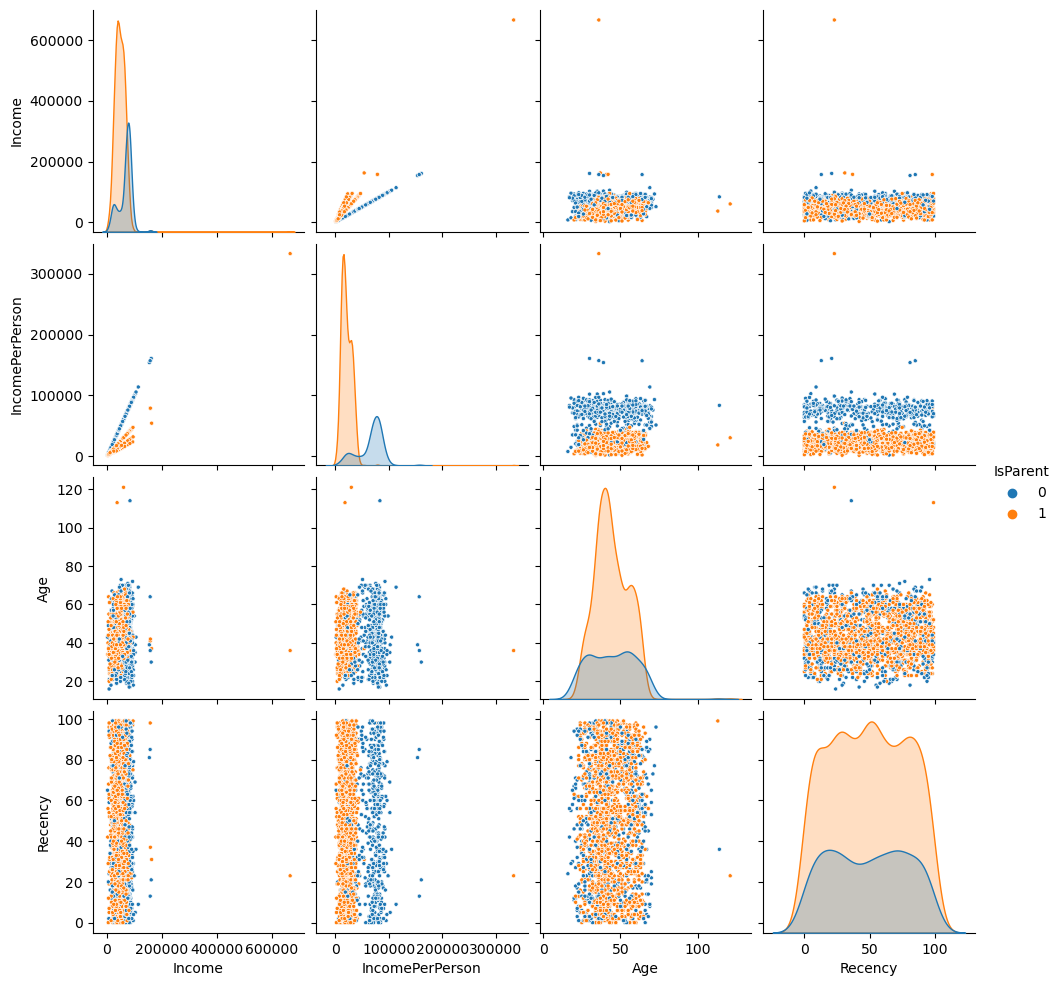

In [60]:
num_cols_pair = ['Income', 'IncomePerPerson', 'Age', 'Recency']
hue = 'IsParent'
plt.figure(figsize=(20, 6))
# smaller points, rotate 
sns.pairplot(data=data, vars=num_cols_pair, hue=hue, markers='.')
plt.show()

<div class="alert alert-block alert-info">

Correlation matrix

</div>

/home/tomruge/anaconda3/envs/env3.12.2/lib/python3.12/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


<Axes: >

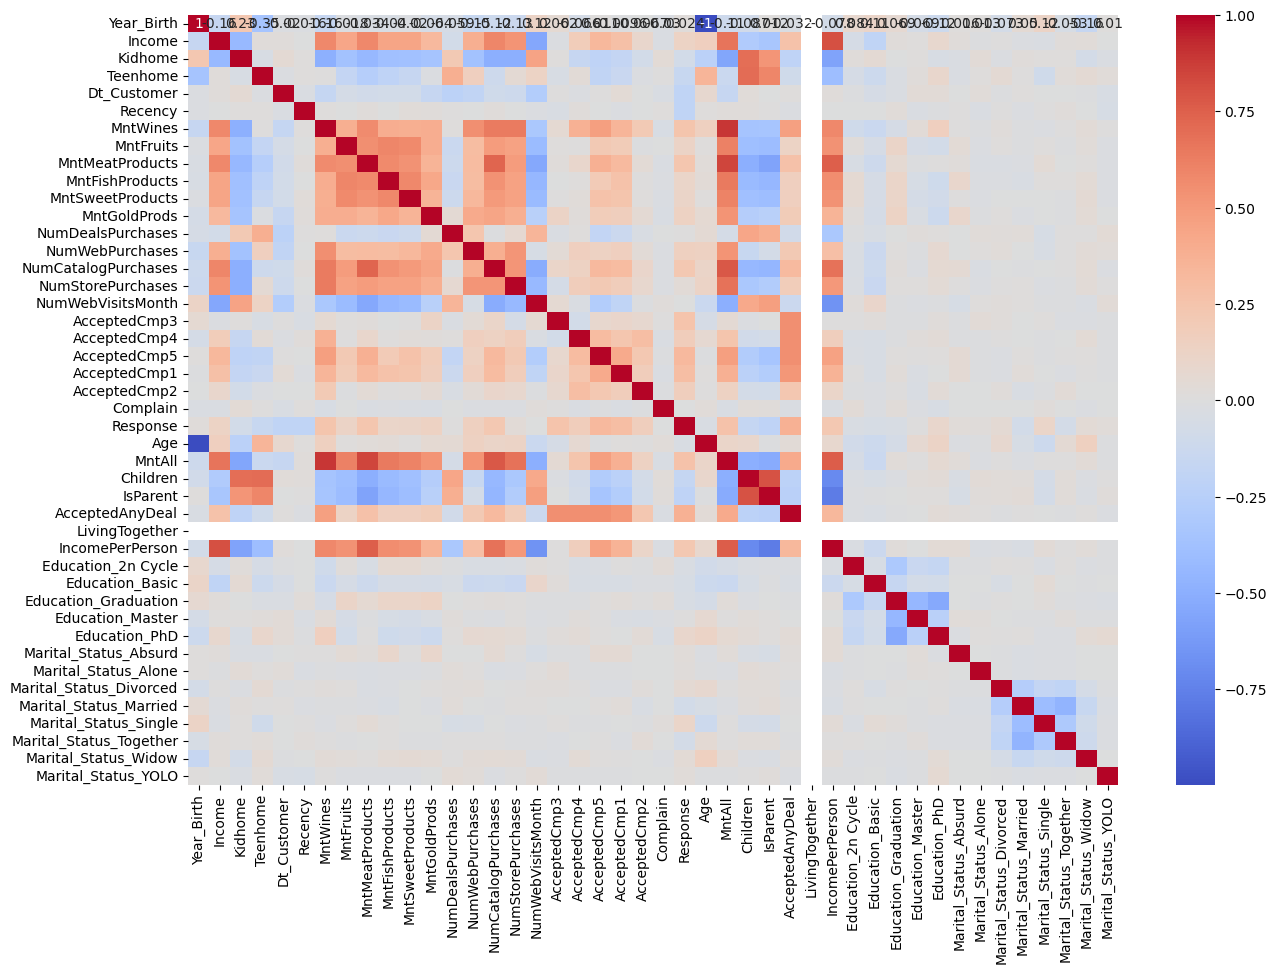

In [70]:
plt.figure(figsize=(15, 10))
sns.heatmap(pd.get_dummies(data).corr(), annot=True, cmap='coolwarm')

<div class="alert alert-block alert-info">
The registrations of customers stayed constant over the time. This means that the business probably did not grow in the two years.

### numeric variables vs categorial variables
</div>

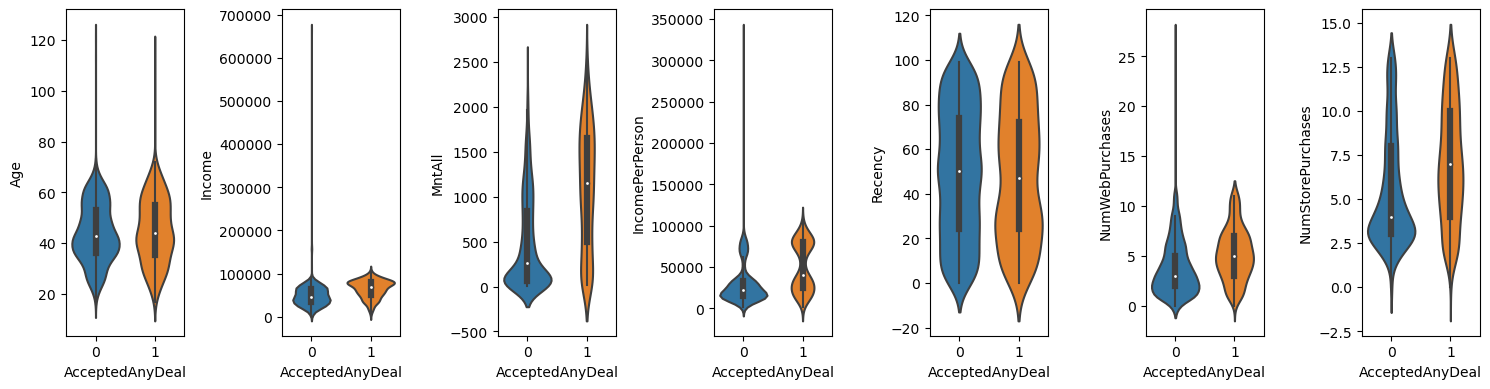

In [76]:
# ### hole spending amount vs. AcceptedAnyDeal in a violinplot
num_cols = ['Age', 'Income', 'MntAll', 'IncomePerPerson', 'Recency', 'NumWebPurchases','NumStorePurchases']
accepted_deal = 'AcceptedAnyDeal'

fig, ax = plt.subplots(1, len(num_cols), figsize=(15, 4))
for col in enumerate(num_cols):
    sns.violinplot(data=data, x=accepted_deal,y=col[1], ax=ax[col[0]])

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
<h2>Clustering</h2>
</div>

<div class="alert alert-block alert-info">
<h3>Special encoding of the attributes</h3>

Education:
- The degree of completion can be considered both ordinal and cardinal. The order of the level of the degree is selected. On ehot encding is used.

Marital_Status:
- The Marital_Status with entries like Divorced, Married, Single, etc... can not be ordinal encoded. Therefore one hot encoding takes place here.

The other attributes are numerical or binary and can therefore be used as they are.

</div>

In [77]:
data.columns

Index(['Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Response', 'Age', 'MntAll', 'Children',
       'IsParent', 'AcceptedAnyDeal', 'LivingTogether', 'IncomePerPerson'],
      dtype='object')

/home/tomruge/anaconda3/envs/env3.12.2/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/tomruge/anaconda3/envs/env3.12.2/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/tomruge/anaconda3/envs/env3.12.2/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/tomruge/anaconda3/envs/env3.12.2/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412:

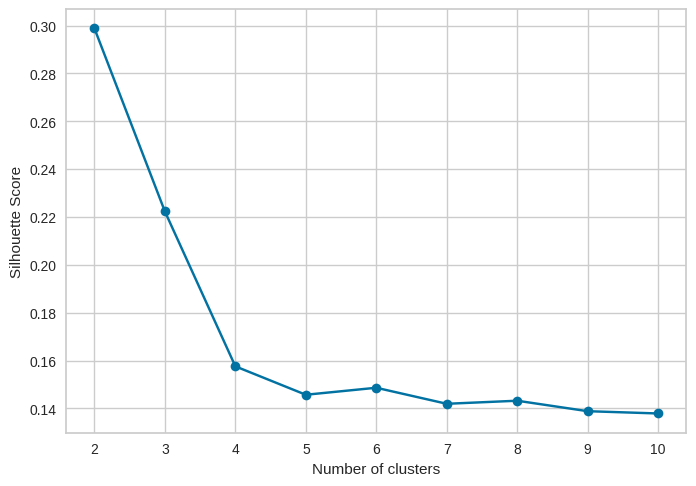

TypeError: float() argument must be a string or a real number, not 'Timestamp'

In [104]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score

# drop the columns with nan
data.dropna(inplace=True)
num_cols = ['Income', 'Kidhome',
       'Teenhome', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 
       'Age', 'MntAll', 'Children', 'IncomePerPerson']

cat_cols = ['Education', 'Marital_Status', 'AcceptedAnyDeal']

bin_col = [ 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response', 'IsParent', 'LivingTogether']

class KMEANS_Wrapper:
    def __init__(self,data, num_cols, cat_cols, bin_cols, min_clusters=1, max_clusters=20):
        self.data = data
        self.min_clusters = min_clusters
        self.max_clusters = max_clusters
        self.num_cols = num_cols
        self.cat_cols = cat_cols
        self.bin_cols = bin_cols

        # used attributes:
        self.used_attributes = self.num_cols + self.cat_cols + self.bin_cols

    def prep_fit_evaluate(self):
        X = self.preprocessor()
        self.find_optimal_clusters(X)
        self.plot_optimal_cluster_knee()

    def preprocessor(self):
        num_pipeline = Pipeline([
            ('scaler', StandardScaler())
        ])
        cat_pipeline = Pipeline([
            ('encoder', OneHotEncoder())
        ])
        preprocessor = ColumnTransformer([
            ('num_scaler', num_pipeline, self.num_cols),
            ('cat_onehot', cat_pipeline, self.cat_cols)
        ])
        return preprocessor.fit_transform(self.data)
    
    def find_optimal_clusters(self, data):
        self.silhouette_scores = []
        for i in range(self.min_clusters, self.max_clusters+1):
            model = KMeans(n_clusters=i, random_state=42)
            silhouette = silhouette_score(data, model.fit_predict(data))
            self.silhouette_scores.append(silhouette)
    
    def plot_optimal_cluster_knee(self):
        plt.plot(range(self.min_clusters, self.max_clusters+1),self.silhouette_scores, marker='o')
        plt.xlabel('Number of clusters')
        plt.ylabel('Silhouette Score')
        plt.show()

    def silhouette_plot(self, n_cluster = 1):
        model = KMeans(n_clusters=n_cluster, random_state=42)
        visualizer = SilhouetteVisualizer(model)
        visualizer.fit(data)
        visualizer.show()

    def fit(self, data):
        X = self.preprocessor(data)
        X = self.select_features(X)
        self.model.fit(X)

model = KMEANS_Wrapper(data = data, num_cols=num_cols, cat_cols=cat_cols, bin_cols=bin_col, min_clusters=2, max_clusters=10)
model.prep_fit_evaluate()
model.silhouette_plot(n_cluster=3)
